# COMP0142

# Assignment 4: Clustering

## Introduction

In this assignment we will implement $k$-Means and Mixture of Gaussians using the `KMeans` and `GaussianMixture` objects from Scikit-learn library.

In Part A of the assignment we will focus on the $k$-Means algorithm. First, we will fit the $k$-Means model to all data and measure its performance. Then, we will split our data in train and test data and measure how well the algorithm performs in both sets. Finally, we will use a different random initialization of the algorithm and explore how it can affect the results.

In Part B of the assignment we will focus on the Mixture of Gaussians algorithm. We will first fit a Gaussian Mixture Model with different covariance matrices to the train data using the `GaussianMixture.fit` method and assign each test sample to the Gaussian it most probably belongs to, using the `GaussianMixture.predict` method. Finally, we will compute the Bayesian Information Criterion (BIC) and the Akaike Information Criterion (AIC) to select the best model for fitting the data.

In Part C of the assignment we will apply the $k$-Means and Mixture of Gaussian models to a different data set (Mice Protein Expression data set). 

## Data sets 

In this assignment we will use two different data sets: 
- The iris  dataset provided by Scikit-learn library, which consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) stored in a 150x4 `numpy.ndarray`. The rows are the samples and the columns are the features: sepal length, sepal width, petal length and petal width. Here, we will only use the first two features/columns.
- The Mice Protein Expression data set consists of the expression levels of 77 proteins/protein modifications that produced detectable signals in the nuclear fraction of cortex. There are 38 control mice and 34 trisomic mice (Down syndrome), for a total of 72 mice. In the experiments, 15 measurements were registered of each protein per sample/mouse. Therefore, for control mice, there are 38x15, or 570 measurements, and for trisomic mice, there are 34x15, or 510 measurements. The dataset contains a total of 1080 measurements per protein. Each measurement can be considered as an independent sample/mouse. For more documentation, please refer to: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression


## Guidelines

- The structure of the code is given to you and you will need to fill in the parts corresponding to each question. 
- You will have to submit the completed notebook in the Jupyter notebook format: `.ipynb`.
- Do not modify/erase other parts of the code if you have not been given specific instructions to do so.
- When you are asked to insert code, do so between the areas which begin:
  
  `##########################################################`
  
  `# TO_DO`
  
  `#[your code here]`
   
   And which end:
   
  `# /TO_DO
   ##########################################################`


- When you are asked to comment on the results you should give clear and comprehensible explanations. Write the comments in a 'Code Cell' with a sign `#` at the beginning of each row, and in the areas which begin:

  `# [INSERT YOUR ANSWER HERE]`

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information in their respective documentations. The most relevant for this assignment is Scikit-learn:

https://scikit-learn.org/stable/

In [1]:
#PLEASE DO NOT CHANGE THIS CELL

#The various imports needed

#Standard python libraries for data analysis and visualisation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#SciKit Learn a python ML Library
#Import models
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

#Load dataset
from sklearn import datasets

#Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

#import useful metrics and linear algebra functions
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix
from scipy import linalg

%matplotlib inline

In [2]:
# PLEASE DO NOT CHANGE THIS CELL
def plot_data(X, y):
    plt.plot(X[y==0, 0], X[y==0, 1],"go", label="Setosa")
    plt.plot(X[y==1, 0], X[y==1, 1],"ro", label="Versicolor")
    plt.plot(X[y==2, 0], X[y==2, 1],"yo", label="Virginica")
    plt.xlabel(iris_dt.feature_names[0],fontsize=10)
    plt.ylabel(iris_dt.feature_names[1],fontsize=10)
    plt.legend()
    
def plot_predictions(y_true,y_pred):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
    
def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel(iris_dt.feature_names[0], fontsize=12)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel(iris_dt.feature_names[3], fontsize=12, rotation=90)
    else:
        plt.tick_params(labelleft='off')
        
def plot_kmeans_results(model, X, y, y_pred):
    #Plot matrix with predictions
    plt.subplot(131)
    plot_predictions(y,y_pred)

    #Plot true labels
    plt.subplot(132)
    plt.title("True labels")
    plot_data(X,y)

    #Plot predicted labels with the decision boundaries
    plt.subplot(133)
    plt.title("Predicted labels")
    plot_decision_boundaries(model, X,y_pred)

# Part A: $k$-Means  [30 marks]

The $k$-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialise $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

We begin by loading and plotting the data. 

In [3]:
# PLEASE DO NOT CHANGE THIS CELL

# LOAD DATA

iris_dt = datasets.load_iris()
print(dir(iris_dt)) #available methods on iris dataset
X = iris_dt.data
X = X[:,[0,1]] 
y = iris_dt.target

#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']


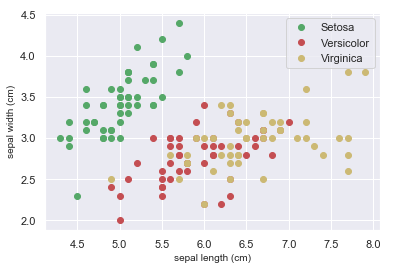

In [4]:
# PLEASE DO NOT CHANGE THIS CELL

# PLOT DATA

plot_data(X,y)    
plt.show()

We first compute a $k$-Means model with $k=3$, fit it to all data and then plot the results.

Accuracy on all data:  51.33333333333333


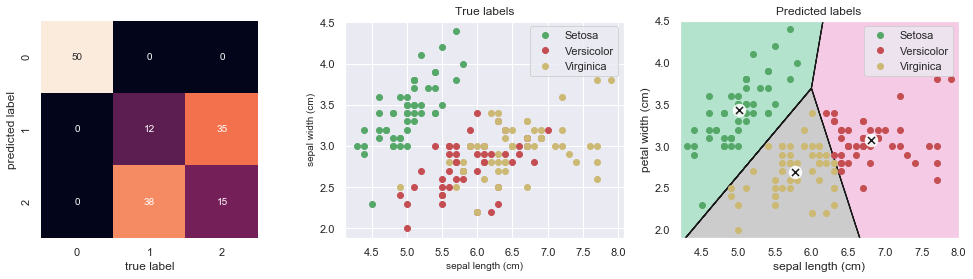

In [5]:
# PLEASE DO NOT CHANGE THIS CELL

kmeans_model1 = KMeans(n_clusters=3, random_state=42)

y_pred = kmeans_model1.fit_predict(X)
print("Accuracy on all data: ", acc(y,y_pred)*100)

plt.figure(figsize=(17, 4))
plot_kmeans_results(kmeans_model1, X, y, y_pred)

### _Question 1_

Using the $k$-Means model defined in the previous cell (with $k=3$ and `random_state=42`):

### _a) [10 marks]_

Fit the model with the train set and predict the labels from the train and test data

### _b) [10 marks]_
Compute the accuracy of the model for the train and test sets and plot the respective matrix with the predictions, the true and predicted labels of both sets (see the subplots created in the previous cell)

The accuracy on the training data is:  25.833333333333336
The accuracy on the test data is:  23.333333333333332


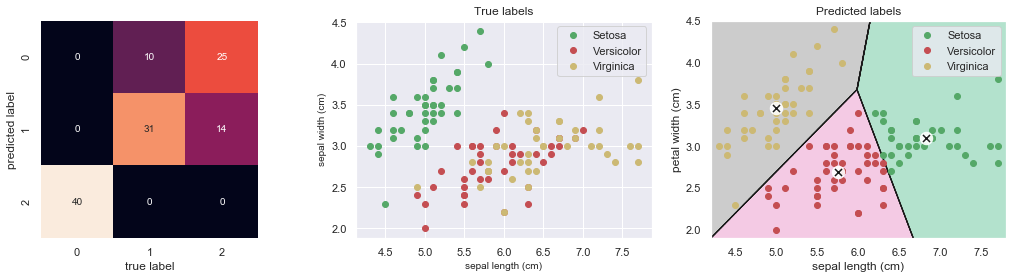

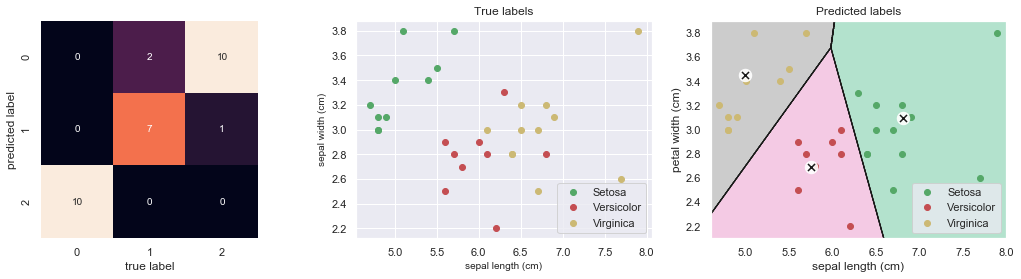

In [6]:
#######################################################
# TO_DO
# [your code here]


# fitting our training data to our k means model
kmeans_model1.fit(X_train)

# predicting labels
X_train_pred = kmeans_model1.predict(X_train)
X_test_pred = kmeans_model1.predict(X_test)

# computing accuracy and printing
accuracy_train = acc(y_train, X_train_pred)*100
accuracy_test = acc(y_test, X_test_pred)*100
print("The accuracy on the training data is: ", accuracy_train)
print("The accuracy on the test data is: ", accuracy_test)

# plotting results
plt.figure(figsize=(18, 4))
plot_kmeans_results(kmeans_model1, X_train, y_train, X_train_pred)

plt.figure(figsize=(18, 4))
plot_kmeans_results(kmeans_model1, X_test, y_test, X_test_pred)


# /TO_DO
########################################################

## $k$-Means Variability 

In the original $k$-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids. However, one major problem with this approach is that if you run $k$-Means multiple times (or with different random seeds), it can converge to very different solutions. 

In [7]:
#PLEASE DO NOT CHANGE THIS CELL

def plot_clusterer_comparison(clusterer1, clusterer2, X,y, title1=None, title2=None):
    y1 = clusterer1.fit_predict(X)
    y2 = clusterer2.fit_predict(X)

    plt.figure(figsize=(16, 4))

    plt.subplot(131)
    plt.title("True labels")
    plot_data(X,y)
    
    plt.subplot(132)
    plot_decision_boundaries(clusterer1, X,y1)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(133)
    plot_decision_boundaries(clusterer2, X,y2, )
    if title2:
        plt.title(title2, fontsize=14)
        
    print("Accuracy solution 1: ", acc(y,y1))
    print("Accuracy solution 2: ", acc(y,y2)) 

### _Question 2_

### _a) [5 marks]_ 

Create a second $k$-Means model with the same number of clusters but with a different random initialization (use `random_state=19`) and use the function defined in the above cell to compare the different models.

Accuracy solution 1:  0.5133333333333333
Accuracy solution 2:  0.08


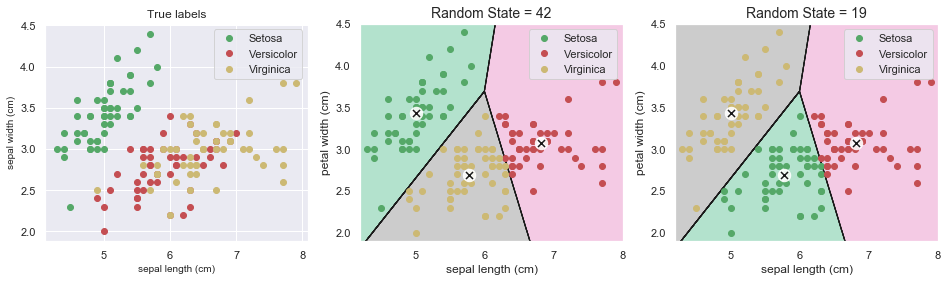

In [8]:
#######################################################
# TO_DO
# [your code here]

kmeans_model2 = KMeans(n_clusters=3, random_state=19)
plot_clusterer_comparison(kmeans_model1, kmeans_model2, X, y, title1="Random State = 42", title2="Random State = 19")

# /TO_DO
##########################################################

### _b) [5 marks]_ 

How did this affect the results? Comment on the results. 

In [9]:
# [INSERT YOUR ANSWER HERE]
#
# We can see most noticably that the accuracy of the model is severely reduced (from 51% to 8%) by the decrease in 
# random state initialisation. Therefore we can infer that the accuracy of this model is heavily dependant on its
# initial given parameters. This is most likely due to the fact that this model is not strictly convex, and can
# converge on other minima than the global minima, meaning a local, not global, optimum is reached.
#

# Part B: Mixture of Gaussians  [60 marks]

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalising the $k$-means algorithm to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The `GaussianMixture` object implements the expectation-maximization (EM) algorithm for fitting mixture of Gaussian models. The `GaussianMixture.fit` method learns a Gaussian Mixture Model from train data and then it can assign to each test sample the Gaussian it most probably belongs to, using the `GaussianMixture.predict` method.

In [10]:
# PLEASE DO NOT CHANGE THIS CELL

colors = ['green', 'red', 'yellow']

def plot_gaussians(X, Y_, means, covariances, covariance_type, index):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, colors)):
        
        if covariance_type == 'full':
            covar = covariances[i][:2, :2]
        elif covariance_type == 'tied':
            covar = covariances[:2, :2]
        elif covariance_type == 'diag':
            covar = np.diag(covariances[i][:2])
        elif covariance_type == 'spherical':
            covar = np.eye(means.shape[1]) * covariances[i]
            
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plot_data(X,Y_)
    plt.xlim(4,8)
    plt.ylim(1.8,4.5)
    plt.title("Predicted labels")

Here, we will fit a Gaussian Mixture Model with 3 components and full covariance to the train data and then make predictions on both train and test data sets.

Accuracy on the train set:  54.166666666666664


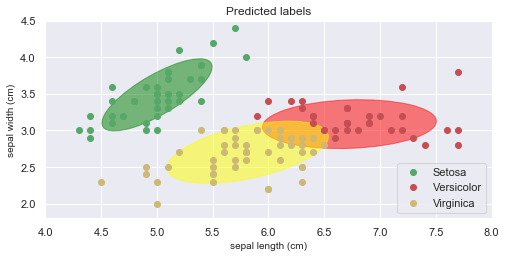

Accuracy on the test set:  53.333333333333336


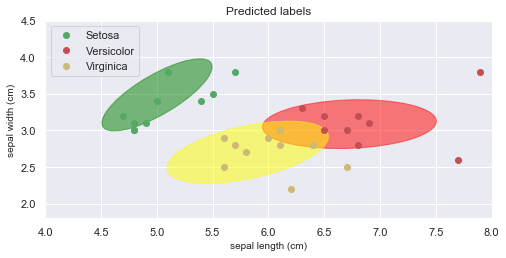

In [11]:
# PLEASE DO NOT CHANGE THIS CELL

gm_full = GaussianMixture(n_components=3,random_state=42, covariance_type='full').fit(X_train)

print("Accuracy on the train set: ", acc(y_train,gm_full.predict(X_train))*100)

plt.figure(figsize=(8, 8))
plot_gaussians(X_train, gm_full.predict(X_train), gm_full.means_, gm_full.covariances_,gm_full.covariance_type, 0)
plt.show()

print("Accuracy on the test set: ", acc(y_test,gm_full.predict(X_test))*100)

plt.figure(figsize=(8, 8))
plot_gaussians(X_test, gm_full.predict(X_test), gm_full.means_, gm_full.covariances_,gm_full.covariance_type, 1)
plt.show()

### _Question 3 [5 marks]_

Comment on the results and compare them with the $k$-Means ones.

In [12]:
# [INSERT YOUR ANSWER HERE]
#
# Our accuracies for the Mixed Gaussian and k-Means models differ greatly, even for test data of the same sizes. For 
# k-Means our accuracies are: train 25.8, test 23.3. For Mixed Gaussian both accuracies are higher at: train 54.2, 
# test 53.3.
# 
# This improvement in train and test accuracy is most likely due to the probabilistic nature of the GMM model. This
# means that each given piece of data can be assigned a probability of classification, and therefore the uncertainty
# in the model is far more accurate than that of k-Means.

### _Question 4_

### _a) [10 marks]_

Use the Gaussian Mixture model created in the previous cell and find a way of recovering the $k$-Means results plotted in **Question 1** (**Hint:** change the covariance matrix of the model)

### _b) [10 marks]_

Display the same plots as presented in the previous cell and compute the accuracy of the model using train and test data as well.

The accuracy on the training set is:  55.00000000000001


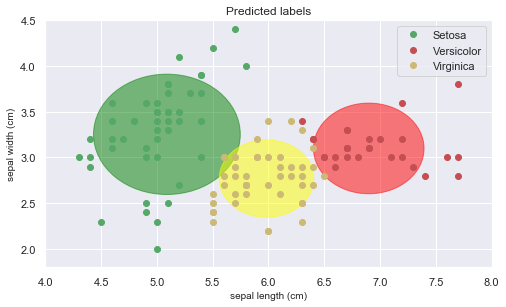

The accuracy on the test set is:  46.666666666666664


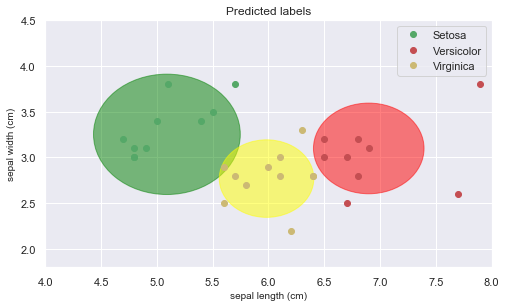

In [13]:
#######################################################
# TO_DO
# [your code here]

GMM_Spher = GaussianMixture(n_components=3,random_state=42, covariance_type='spherical').fit(X_train)
GMM_Spher_train_acc = GMM_Spher.predict(X_train)
GMM_Spher_test_acc = GMM_Spher.predict(X_test)

print("The accuracy on the training set is: ", acc(y_train,GMM_Spher_train_acc)*100)

plt.figure(figsize=(8, 10))
plot_gaussians(X_train, GMM_Spher.predict(X_train), GMM_Spher.means_, GMM_Spher.covariances_,GMM_Spher.covariance_type, 0)
plt.show()

print("The accuracy on the test set is: ", acc(y_test,GMM_Spher_test_acc)*100)

plt.figure(figsize=(8, 10))
plot_gaussians(X_test, GMM_Spher.predict(X_test), GMM_Spher.means_, GMM_Spher.covariances_,GMM_Spher.covariance_type, 1)
plt.show()

# /TO_DO
##########################################################

### _c) [5 marks]_

How comparable are these results with the $k$-Mean results? Comment on the results.

In [14]:
# [INSERT YOUR ANSWER HERE]
#
# Our accuracies for this Mixed Gaussian model are still greatly improved on compared to the k-Means model. For 
# k-Means our accuracies are: train 25.8, test 23.3. For this Mixed Gaussian both accuracies are higher at: train 
# 55.0, test 46.6. Although this is not ideal, and our model should closer fit the k-Means model, it is unavoidable 
# due to the fact that the covarience cannot be kept constant for this particular Python function. To recover k-Means
# completely we would also need to tend the covarience to zero.
#
# Instead of keeping covarience fixed, the covarience type was set to spherical so that the covarience is consistant.
# However the algorithm again is not strictly convex, and the covarience has unfortunatly been altered from a global
# minimum to a local minimum.
#

## Model selection

We have been choosing the number of clusters/components for our models to be equal to the number of classes in the dataset. However, it might not represent the best model to fit the data. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(n)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $n$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalise models that have more parameters to learn (e.g., more clusters/components), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

### _Question 5_

### _a) [10 marks]_

The `GaussianMixture.bic` and `GaussianMixture.aic` methods compute the BIC and AIC values for a specific Gaussian Mixture model, respectively. Using the code below, create two variables called `bics` and `aics` for saving the respective BIC and AIC values and plot the results.

In [15]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 6)]

#######################################################
# TO_DO
# [your code here]

bics = [gm.bic(X) for gm in gms_per_k]
aics = [gm.aic(X) for gm in gms_per_k]

# /TO_DO
##########################################################

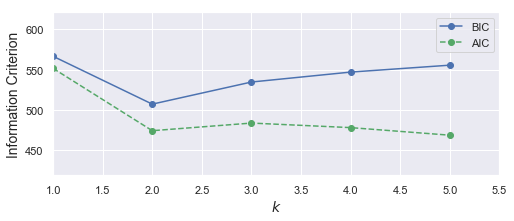

In [16]:
# PLEASE DO NOT CHANGE THIS CELL
plt.figure(figsize=(8, 3))
plt.plot(range(1, 6), bics, "bo-", label="BIC")
plt.plot(range(1, 6), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 5.5, np.min(aics) - 50, np.max(aics) + 70])
plt.legend()
plt.show()

### _b) [10 marks]_

Based on the BIC criterion, choose the best number of components and create `gm_best` variable to store a Gaussian Mixture model with full covariance structure that should best fit the data `X`.

The best accuracy is:  0.6666666666666667
The best number of components is:  2


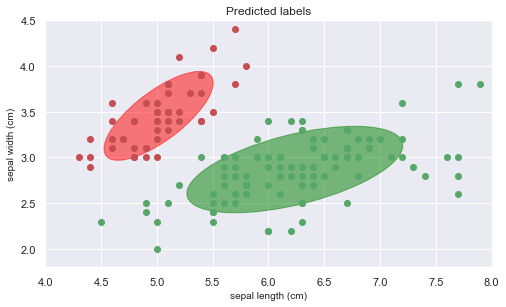

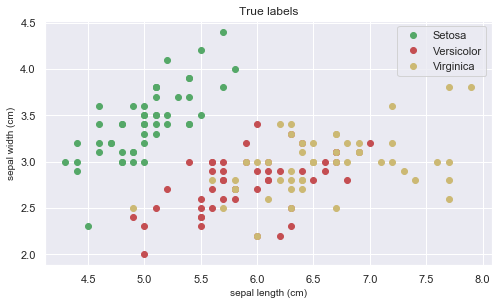

In [17]:
#######################################################
# TO_DO
# [your code here]

gm_best = gms_per_k[1]

best_accuracy = acc(y, gm_best.predict(X))*100
best_components = len(gm_best.covariances_[0])

print("The best accuracy is: ", best_accuracy)
print("The best number of components is: ", best_components)

# /TO_DO
##########################################################

plt.figure(figsize=(8, 10))
plot_gaussians(X, gm_best.predict(X), gm_best.means_, gm_best.covariances_,gm_best.covariance_type, 0)
plt.legend().set_visible(False)
plt.show()

plt.figure(figsize=(8, 4.5))
plt.title("True labels")
plot_data(X,y)
plt.show()

### _c) [10 marks]_

What can you conclude from the new predicted labels (i.e. the labels predicted using the best model)? What could you do to solve the problem?

In [18]:
# [INSERT YOUR ANSWER HERE]
#
# The labels produced by the best model are visually mostly correct, with no clear incorrect bias. There is two clear
# clusters for Setosa and Versicolor/Virginica, which seem to be fitted correctly. It could be said that the cluster 
# spanning both Versicolor and Virginica data points does not cover enough data points, as there are a good few 
# outliers that are not included in the cluster.
#
# The new predicted labels do have a flaw in that there are only 2 clusters present, but 3 categories of data. This 
# means that the more closely located data sets, Versicolor and Virginica, are combined into one cluster. This would
# be easily solved by including 3 clusters in our algorithm. This could be done either by specifying 3 clusters, or by
# assuming that our Setosa cluster is correct, removing these data points or keeping them fixed and then rerunning the
# GMM algorithm in order to sort the rest of the data - which it should now do into 2 clusters as is correct.
#

## Part C: $k$-Means and MoG using Mice Protein Expression Data Set  [10 marks]

We will now apply the $k$-Means and Mixture of Gaussian models to the Mice Protein Expression data set.

In [19]:
from pandas import ExcelWriter
from pandas import ExcelFile

# Load the data set from the excel sheet
df = pd.read_excel('mice_data.xls', sheet_name='genes')
df.fillna(df.median(),inplace=True)

# Store the data in a DataFrame
data = df.values

y = data[:,-1].astype('int')
X = data[:,1:-5]
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### _Question 6_

### _a) [5 marks]_

Create a new $k$-Means model (with `n_clusters=8` and `random_state=42`) and Mixture of Gaussians model (with `n_components=8`, `random_state=42` and `covariance_type=full`). Fit the models to the train data and predict the new labels using the test data.

Accuracy on the test set for k-means:  12.5


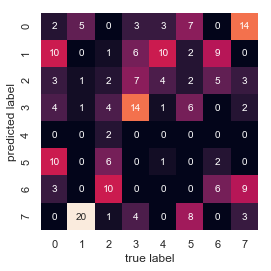

In [20]:
#######################################################
# TO_DO
# [your code here]

kMeans_8 = KMeans(n_clusters = 8, random_state = 42)
kMeans_8.fit(X_train)
y_pred_km = kMeans_8.predict(X_test)

# /TO_DO
##########################################################

print("Accuracy on the test set for k-means: ", acc(y_test,y_pred_km) * 100)
plot_predictions(y_test, y_pred_km)

The accuracy on the train set for GMM is:  17.59259259259259
Accuracy on the test set for MoG:  18.98148148148148


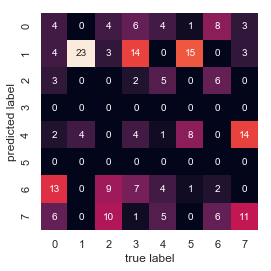

In [21]:
#######################################################
# TO_DO
# [your code here]

GMM_8 = GaussianMixture(n_components=8,random_state=42, covariance_type='full').fit(X)
GMM_8.fit(X_train)
y_pred_mog = GMM_8.predict(X_test)
y_train_mog = GMM_8.predict(X_train)
print("The accuracy on the train set for GMM is: ", acc(y_train,y_train_mog)* 100)

# /TO_DO
##########################################################

print("Accuracy on the test set for MoG: ", acc(y_test,y_pred_mog) * 100)
plot_predictions(y_test, y_pred_mog)

### _b) [5 marks]_

Do you think these models should be applied to this data set? Why? Name one possible explanation for the results obtained.

In [22]:
# [INSERT YOUR ANSWER HERE]
#
# The accuracy for all of these models is very low - all below 20%. GMM shows low accuracy in both test and train
# sets, meaning that this model as well as the k-Means model is not performing well. If one model had to be used, the
# GMM is most ideal, as it does have slightly higher accuracy, as well as being probabilistic in nature meaning the
# results can be analysed from an error standpoint more easily.
#
# The results are most likely low as a hard margin is not present between the data classes, and accounting for a soft
# margin has not been included in the model. This is indicative of the fact that our linear discriminant model is not
# working, and another model needs to be used - perhaps polynomial. A hard margin will occur when there is a clear 
# separation between groups of data, whilst soft occurs when there is some overlap in groups.
#